In [61]:
# Libraries
import seaborn as sns
import pandas as pd
import scipy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors
from matplotlib.lines import Line2D

from biomart import BiomartServer
from io import StringIO
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.tree import export_graphviz

import graphviz
import statsmodels.api as sm

In [20]:
# Mount Google Drive. Permit access when prompted.
from google.colab import drive
from google.colab import files
drive.mount('/content/google_drive')

import os
os.chdir('/content/google_drive/MyDrive/')

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


In [21]:
# Check directory for file names
directory_files = os.listdir('/content/google_drive/MyDrive/440 project E + V 4ever/Data')
for file in directory_files:
  print(file)

All_data.txt
Old data
Patient baseline
Controls
Patient wk12


In [22]:
original_df = pd.read_csv('440 project E + V 4ever/Data/All_data.txt', sep = '\t')
original_df.dropna()
original_df

# Notes on original_df:
# Patients 5, 7, and 12 are missing because they didn't receive biopsies at week 12
# Patients 5, 6, and 7 are non-responders; thus, original_df includes data from a non-responder (patient 6)

,ID_REF,C1,C2,C3,P1_0,P2_0,P3_0,P4_0,P6_0,P8_0,...,P11_0,P1_12,P2_12,P3_12,P4_12,P6_12,P8_12,P9_12,P10_12,P11_12
0,1007_s_at,10.5215,10.8274,10.3693,10.5765,10.8312,10.5242,10.5482,10.2570,10.5092,...,10.4264,10.5843,10.6156,10.4015,10.7438,10.1759,10.2026,10.5832,10.6590,10.3895
1,1053_at,6.8552,6.7757,6.3699,6.2369,6.7993,6.9653,6.8716,6.7159,6.5620,...,6.5778,6.6646,7.0293,6.8159,7.3455,6.5795,6.5322,7.2529,7.0895,6.3157
2,117_at,3.7309,3.9160,4.1976,6.5442,5.9268,5.2193,4.5238,4.1740,4.7661,...,5.7193,5.0663,5.0403,4.7337,4.6863,4.3216,4.1662,4.6153,4.2891,5.1490
3,121_at,3.6326,4.5037,3.1192,3.1939,4.3667,3.3964,3.2283,3.4405,3.7721,...,3.7237,3.2672,3.9808,3.2856,3.6253,3.7397,3.7086,3.6810,4.3130,3.7313
4,1255_g_at,2.3670,2.3441,2.3478,2.5847,2.1721,2.5007,2.3445,2.3325,2.3950,...,2.3518,2.4053,2.4576,2.4955,2.4167,2.5382,2.4897,2.5572,2.4021,2.7009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,2.7630,2.6666,2.5998,2.7451,2.6632,2.5800,2.6701,2.7759,2.6888,...,2.7511,2.6842,2.7534,2.7975,2.5118,2.7033,2.6762,2.6209,2.6997,2.9352
54671,AFFX-ThrX-M_at,2.0498,2.2161,2.2586,2.1532,2.0683,2.0817,2.1490,2.0124,2.1615,...,2.0519,2.1507,2.1778,2.2616,2.1413,2.1011,2.1724,2.2977,2.0997,2.2687
54672,AFFX-TrpnX-3_at,2.0702,2.0976,1.9971,1.9826,2.0452,1.9457,2.0245,1.9737,2.0037,...,2.1885,2.1509,2.0023,1.8615,2.0019,2.0099,1.8929,1.9471,1.9811,2.3038
54673,AFFX-TrpnX-5_at,2.3267,2.3093,2.3798,2.2901,2.3076,2.3861,2.4244,2.3569,2.2092,...,2.2751,2.3538,2.4310,2.2822,2.2464,2.2731,2.3211,2.2894,2.3931,2.6518


In [23]:
# This df only includes controls and responders - drop the non-responder P6
# Controls = columns 1-3 (n = 3)
# Patients t0 = columns 4-11 (n = 8)
# Patients t12 = 12-19 (n = 8)

df_responders = original_df.drop(columns=['P6_0', 'P6_12'])
df_responders

,ID_REF,C1,C2,C3,P1_0,P2_0,P3_0,P4_0,P8_0,P9_0,P10_0,P11_0,P1_12,P2_12,P3_12,P4_12,P8_12,P9_12,P10_12,P11_12
0,1007_s_at,10.5215,10.8274,10.3693,10.5765,10.8312,10.5242,10.5482,10.5092,10.0938,10.9853,10.4264,10.5843,10.6156,10.4015,10.7438,10.2026,10.5832,10.6590,10.3895
1,1053_at,6.8552,6.7757,6.3699,6.2369,6.7993,6.9653,6.8716,6.5620,7.0051,6.4939,6.5778,6.6646,7.0293,6.8159,7.3455,6.5322,7.2529,7.0895,6.3157
2,117_at,3.7309,3.9160,4.1976,6.5442,5.9268,5.2193,4.5238,4.7661,4.9087,4.4371,5.7193,5.0663,5.0403,4.7337,4.6863,4.1662,4.6153,4.2891,5.1490
3,121_at,3.6326,4.5037,3.1192,3.1939,4.3667,3.3964,3.2283,3.7721,4.0848,3.8689,3.7237,3.2672,3.9808,3.2856,3.6253,3.7086,3.6810,4.3130,3.7313
4,1255_g_at,2.3670,2.3441,2.3478,2.5847,2.1721,2.5007,2.3445,2.3950,2.3723,2.2990,2.3518,2.4053,2.4576,2.4955,2.4167,2.4897,2.5572,2.4021,2.7009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,2.7630,2.6666,2.5998,2.7451,2.6632,2.5800,2.6701,2.6888,2.7270,2.7959,2.7511,2.6842,2.7534,2.7975,2.5118,2.6762,2.6209,2.6997,2.9352
54671,AFFX-ThrX-M_at,2.0498,2.2161,2.2586,2.1532,2.0683,2.0817,2.1490,2.1615,2.1578,2.1847,2.0519,2.1507,2.1778,2.2616,2.1413,2.1724,2.2977,2.0997,2.2687
54672,AFFX-TrpnX-3_at,2.0702,2.0976,1.9971,1.9826,2.0452,1.9457,2.0245,2.0037,2.0729,1.9118,2.1885,2.1509,2.0023,1.8615,2.0019,1.8929,1.9471,1.9811,2.3038
54673,AFFX-TrpnX-5_at,2.3267,2.3093,2.3798,2.2901,2.3076,2.3861,2.4244,2.2092,2.3552,2.2898,2.2751,2.3538,2.4310,2.2822,2.2464,2.3211,2.2894,2.3931,2.6518


In [24]:
# Groups

controls = pd.DataFrame(columns = ['C0', 'C1', 'C2'])
controls['C0'] = df_responders.iloc[:,1]
controls['C1'] = df_responders.iloc[:,2]
controls['C2'] = df_responders.iloc[:,3]

p0 = pd.DataFrame(columns = ['P1', 'P2', 'P3','P4', 'P8', 'P9','P10', 'P11'])
p0['P1'] = df_responders.iloc[:,4]
p0['P2'] = df_responders.iloc[:,5]
p0['P3'] = df_responders.iloc[:,6]
p0['P4'] = df_responders.iloc[:,7]
p0['P8'] = df_responders.iloc[:,8]
p0['P9'] = df_responders.iloc[:,9]
p0['P10'] = df_responders.iloc[:,10]
p0['P11'] = df_responders.iloc[:,11]

p12 = pd.DataFrame(columns = ['P1', 'P2', 'P3','P4', 'P8', 'P9','P10', 'P11'])
p12['P1'] = df_responders.iloc[:,12]
p12['P2'] = df_responders.iloc[:,13]
p12['P3'] = df_responders.iloc[:,14]
p12['P4'] = df_responders.iloc[:,15]
p12['P8'] = df_responders.iloc[:,16]
p12['P9'] = df_responders.iloc[:,17]
p12['P10'] = df_responders.iloc[:,18]
p12['P11'] = df_responders.iloc[:,19]

In [25]:
# Test each group (controls, P_0, P_12) for normality

normal_results = []
for a in range(len(df_responders)):
  s_test_c, s_p_c = scipy.stats.shapiro(controls.iloc[a,:])

  s_test_p0, s_p_p0 = scipy.stats.shapiro(p0.iloc[a,:])

  s_test_p12, s_p_p12 = scipy.stats.shapiro(p12.iloc[a,:])

  normal_results.append({
    'ID_REF': df_responders.iloc[a, 0],
    'C_pvalue': s_p_c,
    'P0_pvalue': s_p_p0,
    'P12_pvalue': s_p_p12
  })

shapiro_results = pd.DataFrame(normal_results)
shapiro_results

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1887: RuntimeWarning: invalid value encountered in arccos
  pw = 1 - 6/np.pi*np.arccos(np.sqrt(w))


,ID_REF,C_pvalue,P0_pvalue,P12_pvalue
0,1007_s_at,0.634566,0.590677,0.498659
1,1053_at,0.292807,0.613261,0.846456
2,117_at,0.773076,0.520142,0.463357
3,121_at,0.717202,0.700522,0.500172
4,1255_g_at,0.288509,0.845691,0.094099
...,...,...,...,...
54670,AFFX-ThrX-5_at,0.800735,0.852600,0.928261
54671,AFFX-ThrX-M_at,0.370100,0.111853,0.432266
54672,AFFX-TrpnX-3_at,0.509658,0.737649,0.213270
54673,AFFX-TrpnX-5_at,0.456772,0.868417,0.080167


In [26]:
# There are a large number of non-normal distributions in our data, so use non-parametric statistics for DEG analysis
# Mann-Whitney U test

mann_results = []
for a in range(len(df_responders)):
  c_p0_test, c_p0_p = scipy.stats.mannwhitneyu(controls.iloc[a,:],p0.iloc[a,:])

  log2fc_1 = np.mean(p0.iloc[a,:])-np.mean(controls.iloc[a,:])

  c_p12_test, c_p12_p = scipy.stats.mannwhitneyu(controls.iloc[a,:],p12.iloc[a,:])

  log2fc_2 = np.mean(p12.iloc[a,:])-np.mean(controls.iloc[a,:])

  p0_p12_test, p0_p12_p = scipy.stats.mannwhitneyu(p0.iloc[a,:],p12.iloc[a,:])

  log2fc_3 = np.mean(p12.iloc[a,:])-np.mean(p0.iloc[a,:])

  mann_results.append({
    'ID_REF': df_responders.iloc[a, 0],
    'C vs P0 pvalue': c_p0_p,
    'C vs P0 log2fc': log2fc_1,
    'C vs P12 pvalue': c_p12_p,
    'C vs P12 log2fc': log2fc_2,
    'P0 vs P12 pvalue': p0_p12_p,
    'P0 vs P12 log2fc': log2fc_3
  })

mann_whitney_results = pd.DataFrame(mann_results)
mann_whitney_results

KeyboardInterrupt: 

In [27]:
# Student's T test

t_results = []
for a in range(len(df_responders)):
  c_p0_test, c_p0_p = scipy.stats.ttest_ind(controls.iloc[a,:],p0.iloc[a,:])

  log2fc_1 = np.mean(p0.iloc[a,:])-np.mean(controls.iloc[a,:])

  c_p12_test, c_p12_p = scipy.stats.ttest_ind(controls.iloc[a,:],p12.iloc[a,:])

  log2fc_2 = np.mean(p12.iloc[a,:])-np.mean(controls.iloc[a,:])

  p0_p12_test, p0_p12_p = scipy.stats.ttest_ind(p0.iloc[a,:],p12.iloc[a,:])

  log2fc_3 = np.mean(p12.iloc[a,:])-np.mean(p0.iloc[a,:])

  t_results.append({
    'ID_REF': df_responders.iloc[a, 0],
    'C vs P0 pvalue': c_p0_p,
    'C vs P0 log2fc': log2fc_1,
    'C vs P12 pvalue': c_p12_p,
    'C vs P12 log2fc': log2fc_2,
    'P0 vs P12 pvalue': p0_p12_p,
    'P0 vs P12 log2fc': log2fc_3
  })

t_test_results = pd.DataFrame(t_results)
t_test_results

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,ID_REF,C vs P0 pvalue,C vs P0 log2fc,C vs P12 pvalue,C vs P12 log2fc,P0 vs P12 pvalue,P0 vs P12 log2fc
0,1007_s_at,0.951825,-0.010883,0.705914,-0.050296,0.731947,-0.039413
1,1053_at,0.904579,0.022054,0.378799,0.213767,0.246116,0.191713
2,117_at,0.017717,1.307496,0.008176,0.770108,0.087874,-0.537387
3,121_at,0.889748,-0.047483,0.865599,-0.052733,0.978328,-0.005250
4,1255_g_at,0.749181,0.024546,0.047384,0.137658,0.065133,0.113112
...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,0.596712,0.026183,0.682779,0.033396,0.887629,0.007212
54671,AFFX-ThrX-M_at,0.319312,-0.048821,0.706411,0.021404,0.038447,0.070225
54672,AFFX-TrpnX-3_at,0.551074,-0.033104,0.681502,-0.037279,0.944891,-0.004175
54673,AFFX-TrpnX-5_at,0.626132,-0.021412,0.685474,0.032500,0.312851,0.053913


In [34]:
unique_affy_ids = t_test_results['ID_REF'].unique()  # Ensure unique IDs

# Connect to the BioMart server
server = BiomartServer("http://www.ensembl.org/biomart")

# Select the appropriate dataset; for human genes, use 'hsapiens_gene_ensembl'
dataset = server.datasets['hsapiens_gene_ensembl']

# Perform the search
# Adjust 'attributes' and 'filters' accordingly
# Affymetrix array used: 'affy_hg_u133_plus_2'
response = dataset.search({
    'filters': {
        'with_affy_hg_u133_plus_2': True  # Get all genes with Affy HG U133 Plus 2.0
    },
    'attributes': [
        'affy_hg_u133_plus_2',  # Affymetrix ID
        'ensembl_gene_id',     # Ensembl Gene ID
        'external_gene_name'   # Gene name
    ]
})

# Convert the response text to a DataFrame
hsapiens_ensembl = pd.read_csv(StringIO(response.text), sep='\t', names=['ID_REF', 'Ensembl_ID', 'Gene_Name'])

# Merge to find matches
matched_data_filtered = hsapiens_ensembl[hsapiens_ensembl['ID_REF'].isin(unique_affy_ids)]

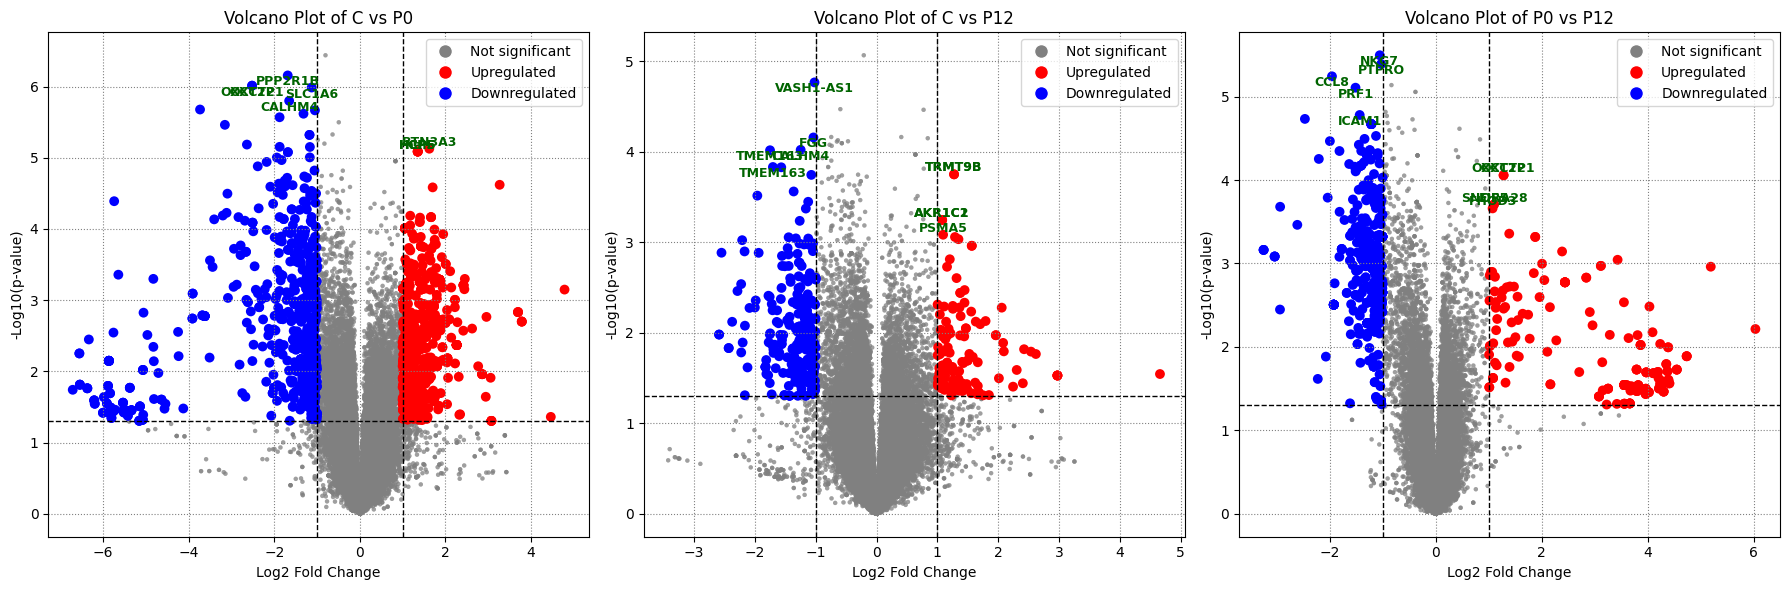

In [71]:
# Calculate -log10(p-value) for the y-axis for all comparisons
t_test_results['neg_log10_C vs P0 pvalue'] = -np.log10(t_test_results['C vs P0 pvalue'])
t_test_results['neg_log10_C vs P12 pvalue'] = -np.log10(t_test_results['C vs P12 pvalue'])
t_test_results['neg_log10_P0 vs P12 pvalue'] = -np.log10(t_test_results['P0 vs P12 pvalue'])

# Create subplots for each comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Titles for the subplots
titles = ['C vs P0', 'C vs P12', 'P0 vs P12']

# Merge t_test_results with gene names for annotation
t_test_results_with_genes = t_test_results.merge(matched_data_filtered, on='ID_REF', how='left')

# Define thresholds for significance
logfc_threshold = 1  # log fold change threshold
pvalue_threshold = 0.05  # p-value threshold

# Custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not significant',
           markerfacecolor='grey', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Upregulated',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Downregulated',
           markerfacecolor='blue', markersize=10),
]


# Iterate over the comparisons to create each subplot
for i, (logfc_col, pval_col, title) in enumerate(zip(
        ['C vs P0 log2fc', 'C vs P12 log2fc', 'P0 vs P12 log2fc'],
        ['neg_log10_C vs P0 pvalue', 'neg_log10_C vs P12 pvalue', 'neg_log10_P0 vs P12 pvalue'],
        titles)):

    # Scatter plot of non-significant points
    axes[i].scatter(
        x=t_test_results[logfc_col],
        y=t_test_results[pval_col],
        s=10,  # smaller marker size for non-significant points
        alpha=0.5,  # slightly transparent
        color='grey',  # grey color for non-significant points
        edgecolors='none'  # no edge color to markers
    )


    # Filter significant and non-significant points
    significant_up = t_test_results_with_genes[
        (t_test_results_with_genes[logfc_col] >= logfc_threshold) &
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] <= pvalue_threshold)
    ]
    significant_down = t_test_results_with_genes[
        (t_test_results_with_genes[logfc_col] <= -logfc_threshold) &
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] <= pvalue_threshold)
    ]
    non_significant = t_test_results_with_genes[
        (abs(t_test_results_with_genes[logfc_col]) < logfc_threshold) |
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] > pvalue_threshold)
    ]

    # Scatter plot of non-significant points
    axes[i].scatter(
        x=non_significant[logfc_col],
        y=non_significant[pval_col],
        s=10,  # smaller marker size for non-significant points
        alpha=0.5,  # slightly transparent
        color='grey',  # grey color for non-significant points
        edgecolors='none'  # no edge color to markers
    )

    # Scatter plot of significant upregulated points
    axes[i].scatter(
        x=significant_up[logfc_col],
        y=significant_up[pval_col],
        s=50,  # larger marker size for significant points
        color='red',  # red color for significant upregulated points
        edgecolors='none'
    )

    # Scatter plot of significant downregulated points
    axes[i].scatter(
        x=significant_down[logfc_col],
        y=significant_down[pval_col],
        s=50,  # larger marker size for significant points
        color='blue',  # blue color for significant downregulated points
        edgecolors='none'
    )

    # For upregulated genes, this means the largest positive fold change
    top_genes_up = significant_up.sort_values(
        by=[pval_col.replace('neg_log10_', ''), logfc_col], ascending=[True, False]
        ).head(5)

    # For downregulated genes, this means the largest negative fold change
    top_genes_down = significant_down.sort_values(
        by=[pval_col.replace('neg_log10_', ''), logfc_col], ascending=[True, True]
        ).head(5)

    # Select top genes by smallest p-value for upregulated and downregulated
    #top_genes_up = significant_up.nsmallest(5, pval_col.replace('neg_log10_', ''))
    #top_genes_down = significant_down.nsmallest(5, pval_col.replace('neg_log10_', ''))

    # Combine top upregulated and downregulated genes
    top_genes = pd.concat([top_genes_up, top_genes_down])

    # Annotate top genes
    for _, row in top_genes.iterrows():
        ha = 'center'
        va = 'bottom' if row[logfc_col] > 0 else 'top'
        axes[i].text(
            row[logfc_col],
            row[pval_col],
            row['Gene_Name'],
            ha=ha,
            va=va,
            fontsize=9,  # Adjust fontsize according to your plot size
            color='darkgreen',  # Choose a color that is visible
            weight='bold',  # Bold text to make it stand out
            clip_on=True,  # Prevent clipping at edges
        )
    # Adding the legend to each subplot
    axes[i].legend(handles=legend_elements, loc='upper right')

    # Enhancing each subplot
    axes[i].set_title(f'Volcano Plot of {title}')
    axes[i].set_xlabel('Log2 Fold Change')
    axes[i].set_ylabel('-Log10(p-value)')
    axes[i].axhline(y=-np.log10(pvalue_threshold), color='black', linestyle='--', linewidth=1)
    axes[i].axvline(x=logfc_threshold, color='black', linestyle='--', linewidth=1)
    axes[i].axvline(x=-logfc_threshold, color='black', linestyle='--', linewidth=1)
    axes[i].grid(True, linestyle=':', color='grey')  # Add a dotted grid for better readability

plt.tight_layout()
plt.show()
